In [125]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import os

from collections import namedtuple
from scipy.signal import find_peaks


TARGET_DIR = "segmented_digits/"
AUDIO_DIR = "audios/"  # each person audios should be stored inside its own directory
METHOD = "mid_values"  # "start_end" or "mid_values"

START_END_SPAN = 0.35  # seconds to add before and after the start and end of the digit
MID_VALUES_SPAN = 0.5  # seconds to add before and after the mid value of the digit
SPEECH_THRESHOLD = 0.05  # energy threshold to consider a frame as speech
DISPERSION = 0.5  # minimum separation in seconds between two energy peaks to be considered different digits


if METHOD not in ["start_end", "mid_values"]:
    raise ValueError("Invalid method")

Signal = namedtuple("Signal", ["y", "fs", "file"])


def signal_from_file(filename):
    fs, y = wav.read(filename)
    y = y / 2**15

    return Signal(y, fs, os.path.basename(filename))


def plot_signal(y, fs, title, peaks=None, hlines=None, vlines=None):
    t = np.arange(len(y)) / fs
    plt.plot(t, y)

    if peaks is not None:
        plt.plot(peaks / fs, y[peaks], "x")

    if hlines is not None:
        for y in hlines:
            plt.axhline(y, color="r", linestyle="--")

    if vlines is not None:
        for x in vlines:
            plt.axvline(x, color="r", linestyle="--")

    plt.xlabel("Time (s)")
    plt.title(title)
    plt.show()


def non_overlapping_frames(signal, frame_duration):
    frame_len = round(frame_duration * signal.fs)
    total_frames = len(signal.y) // frame_len

    frames = signal.y[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


def speech_segments(signal, energy_threshold, dispersion, method="mid_values"):
    plot_signal(signal.y, signal.fs, title=f"{signal.file}")

    frame_duration = 0.02
    frames_fs = 1 / frame_duration
    frames = non_overlapping_frames(signal, frame_duration)

    energy_frames = np.sum(frames**2, axis=0)
    energy_peaks, _ = find_peaks(
        energy_frames, height=energy_threshold * np.max(energy_frames)
    )

    last_peak = energy_peaks[0]
    current_peaks = []
    energy_mid_values = []
    digit_start_end = []
    for peak in energy_peaks:
        if peak - last_peak < dispersion * frames_fs:
            current_peaks.append(peak)
        else:
            energy_mid_values.append(np.mean(current_peaks))
            digit_start_end.append((current_peaks[0], current_peaks[-1]))
            current_peaks = [peak]

        last_peak = peak

    energy_mid_values.append(np.mean(current_peaks))
    digit_start_end.append((current_peaks[0], current_peaks[-1]))

    energy_mid_values = np.array(energy_mid_values)
    signal_mid_values = np.array(energy_mid_values) / frames_fs
    digit_start_end = np.array(digit_start_end) / frames_fs

    plot_signal(
        energy_frames,
        frames_fs,
        title=f"Energy {signal.file} peaks",
        hlines=[energy_threshold * np.max(energy_frames)],
        peaks=energy_peaks,
    )

    if method == "mid_values":
        plot_signal(
            energy_frames,
            frames_fs,
            title=f"Energy {signal.file} mid values",
            peaks=energy_mid_values.astype(int),
        )

        plot_signal(
            signal.y,
            signal.fs,
            title=f"{signal.file} mid values",
            vlines=signal_mid_values,
        )

    if method == "mid_values":
        vlines = np.array(
            [
                (
                    value - MID_VALUES_SPAN,
                    value + MID_VALUES_SPAN,
                )
                for value in signal_mid_values
            ]
        )
    elif method == "start_end":
        vlines = np.array(
            [
                ((start - START_END_SPAN, end + START_END_SPAN))
                for start, end in digit_start_end
            ]
        )

    plot_signal(
        signal.y,
        signal.fs,
        title=f"{signal.file} speech segments",
        vlines=vlines.flatten(),
    )

    empty_signal_duration = 0.5
    empty_signal_len = round(empty_signal_duration * signal.fs)
    empty_signal = np.zeros(empty_signal_len)

    speech_segments = []

    if method == "mid_values":
        for i, value in enumerate(signal_mid_values):
            digit_start = round((value - MID_VALUES_SPAN) * signal.fs)
            digit_end = round((value + MID_VALUES_SPAN) * signal.fs)
            digit = np.concatenate(
                [empty_signal, signal.y[digit_start:digit_end], empty_signal]
            )

            plot_signal(digit, signal.fs, title=f"{signal.file} number {i}")
            speech_segments.append(digit)

    elif method == "start_end":
        for i, (start, end) in enumerate(digit_start_end):
            digit_start = round((start - START_END_SPAN) * signal.fs)
            digit_end = round((end + START_END_SPAN) * signal.fs)
            digit = np.concatenate(
                [empty_signal, signal.y[digit_start:digit_end], empty_signal]
            )

            plot_signal(digit, signal.fs, title=f"{signal.file} number {i}")
            speech_segments.append(digit)

    return speech_segments

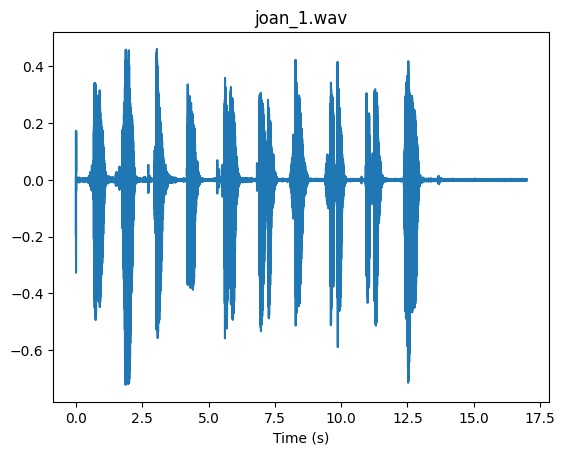

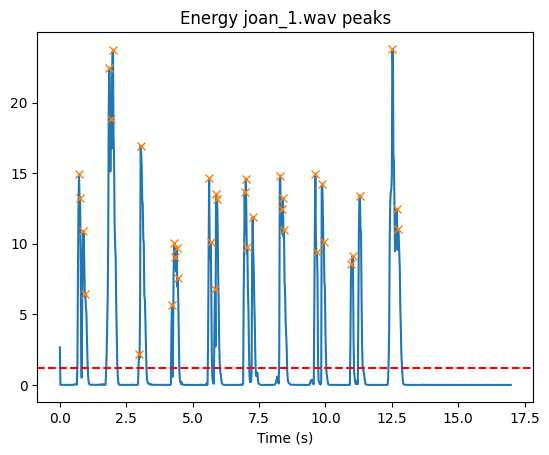

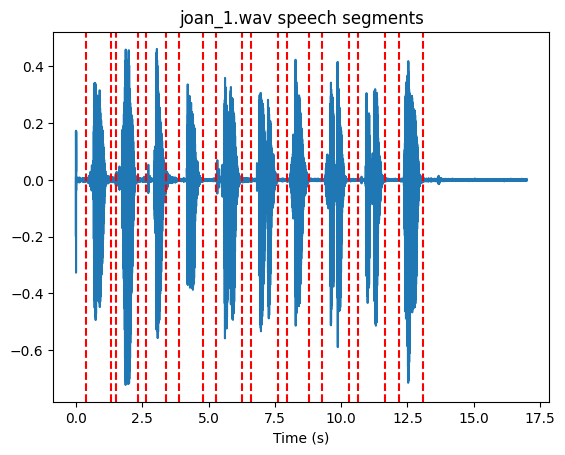

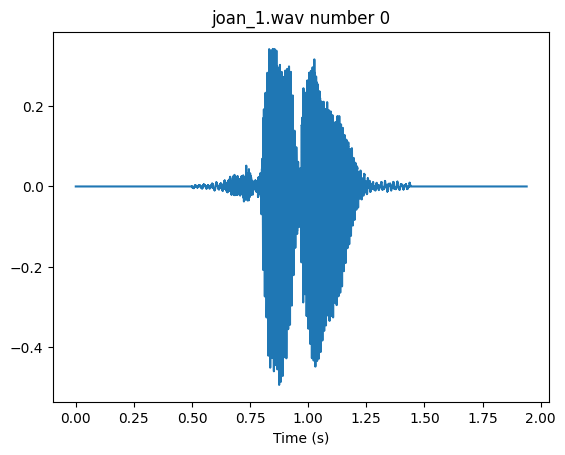

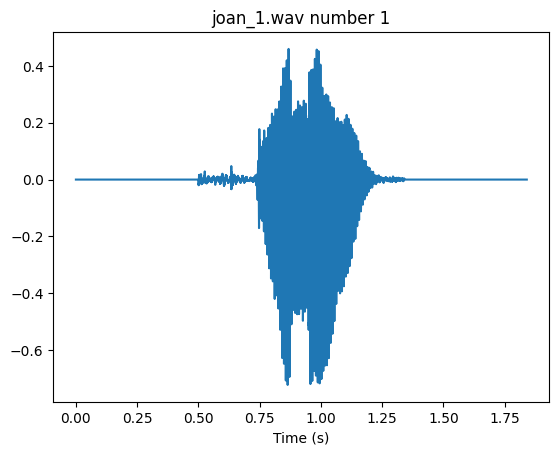

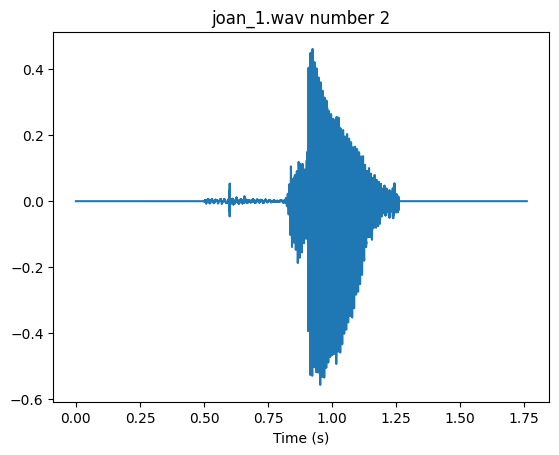

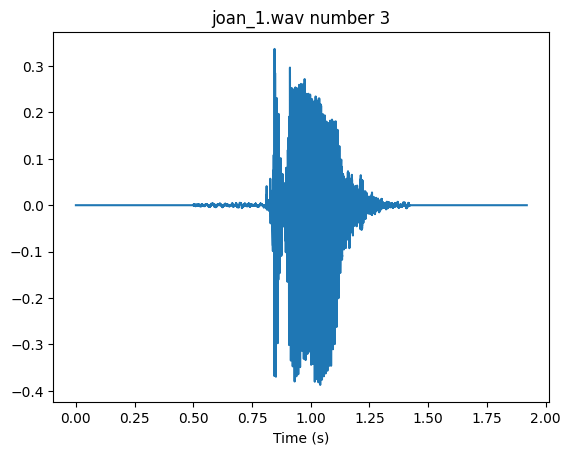

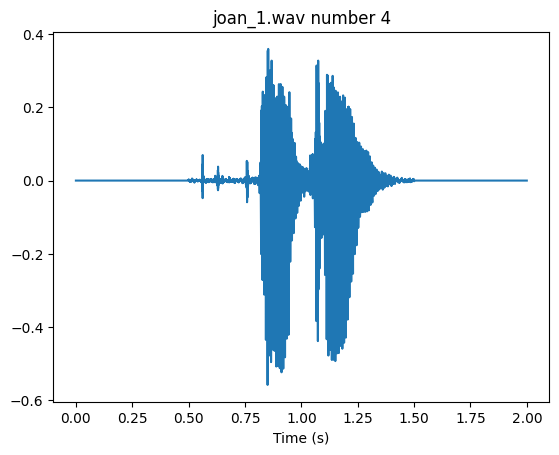

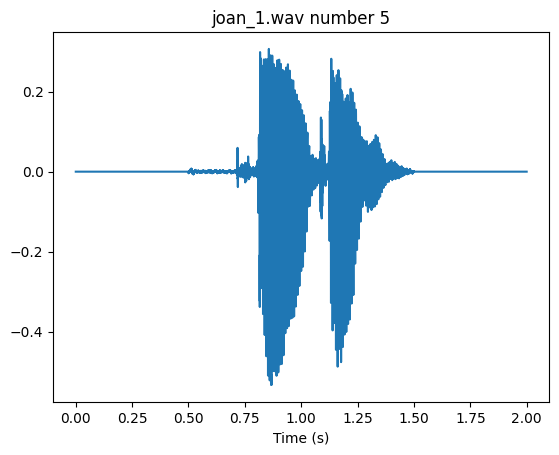

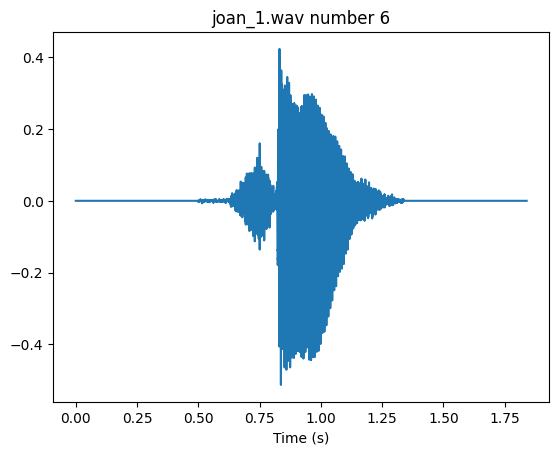

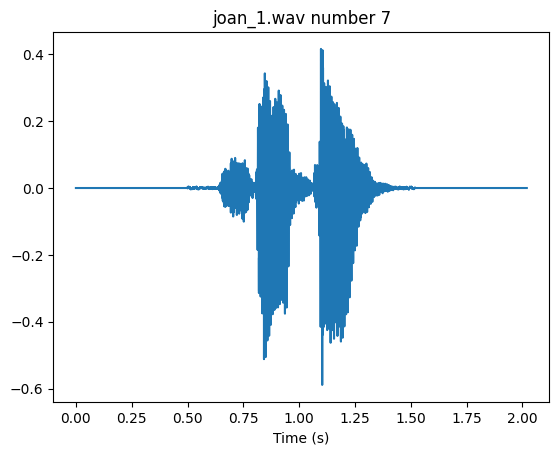

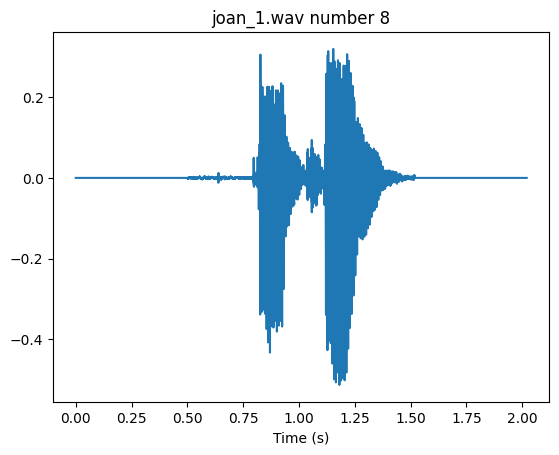

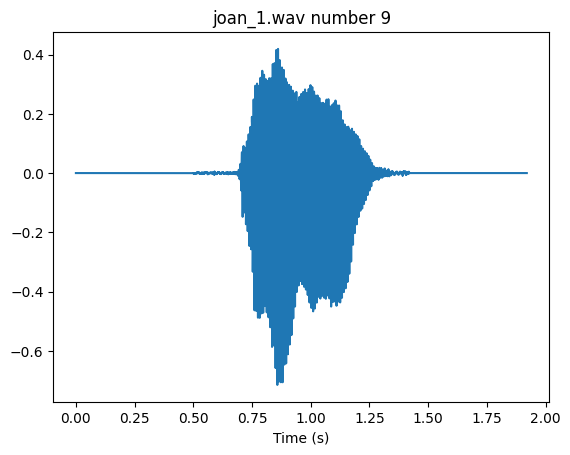

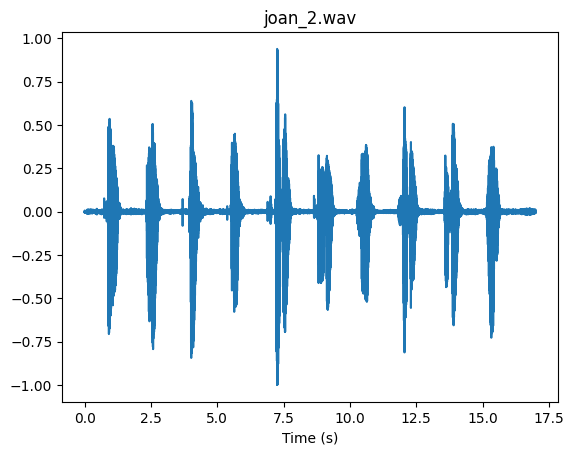

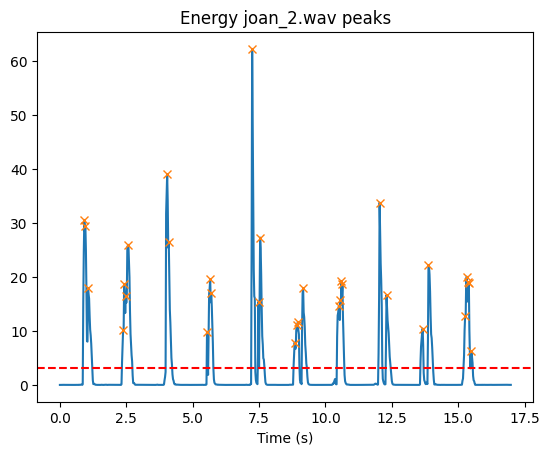

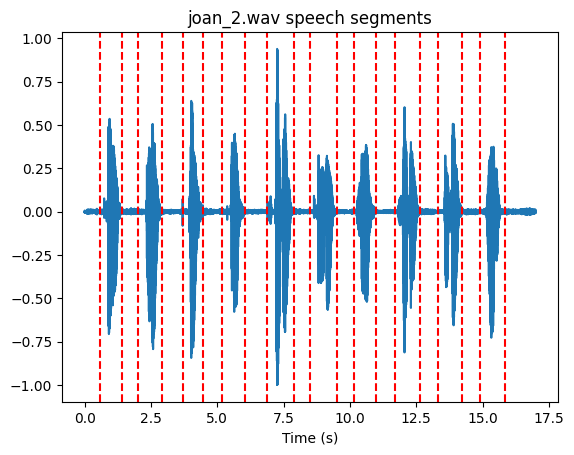

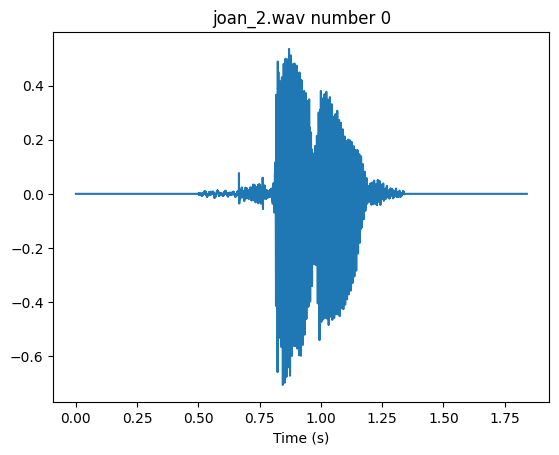

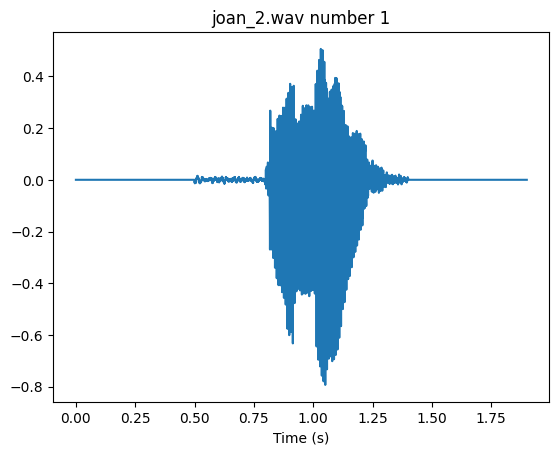

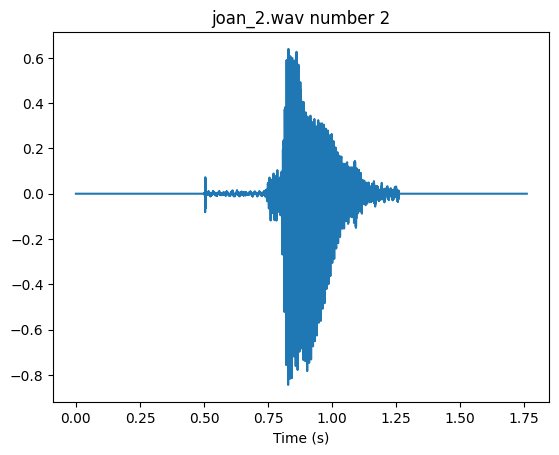

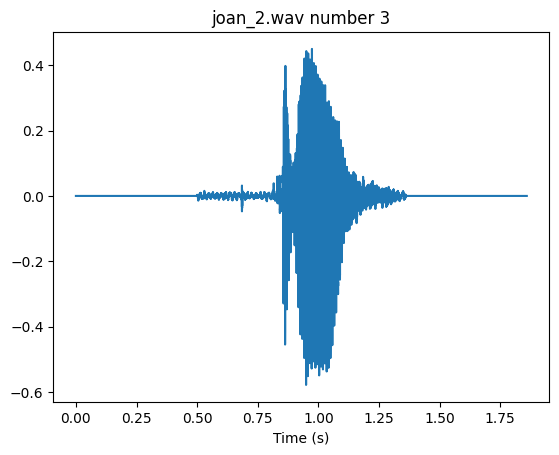

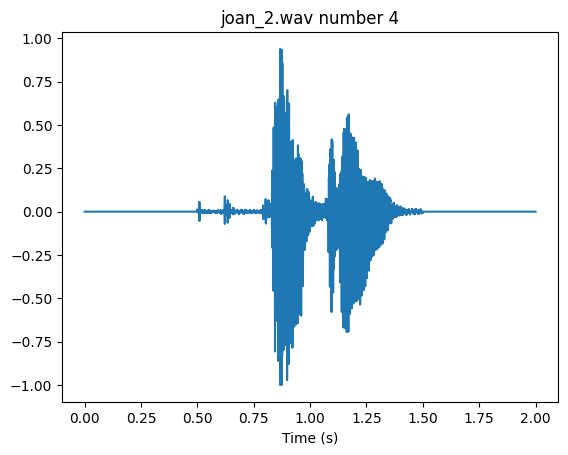

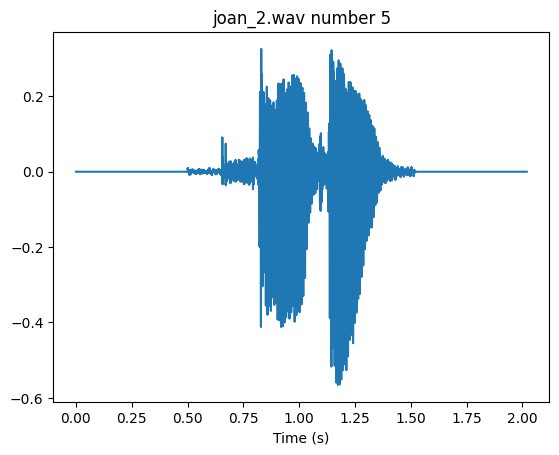

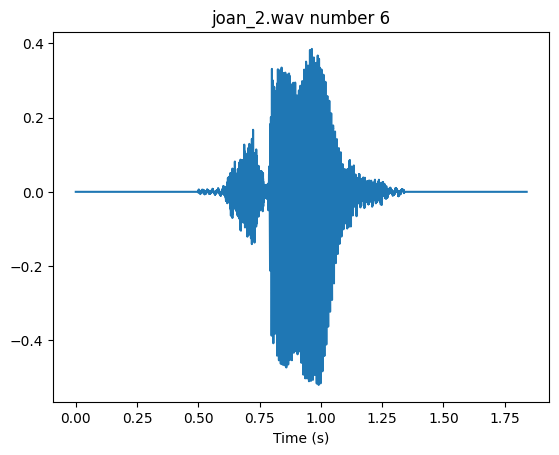

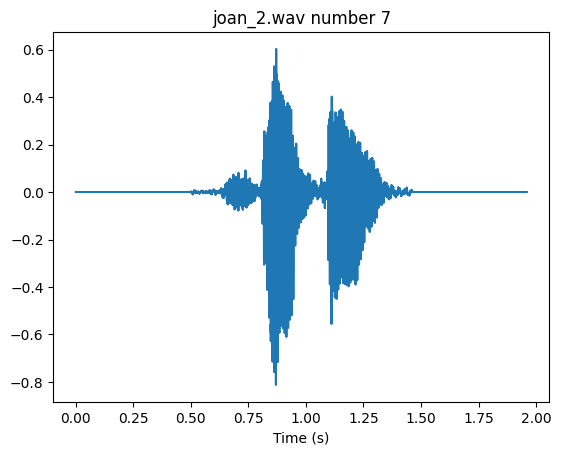

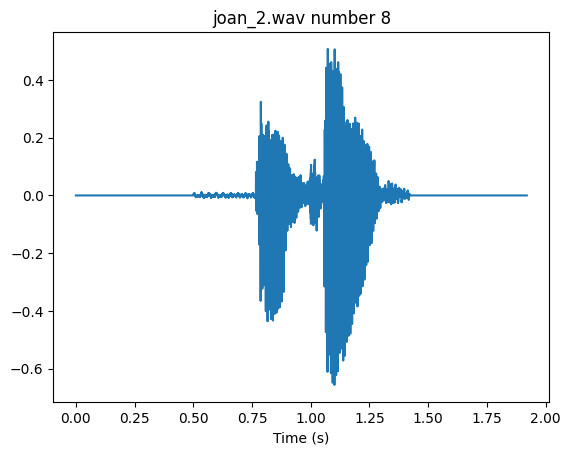

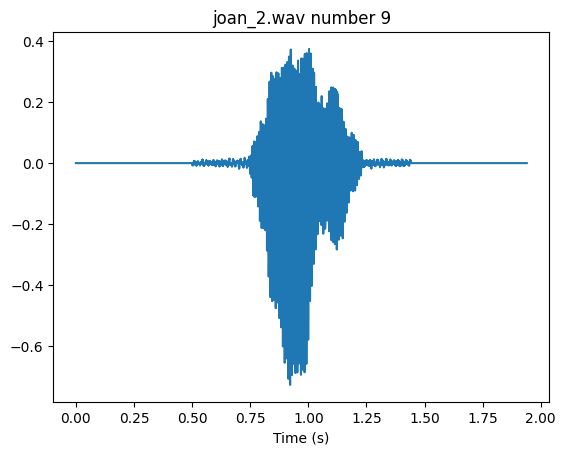

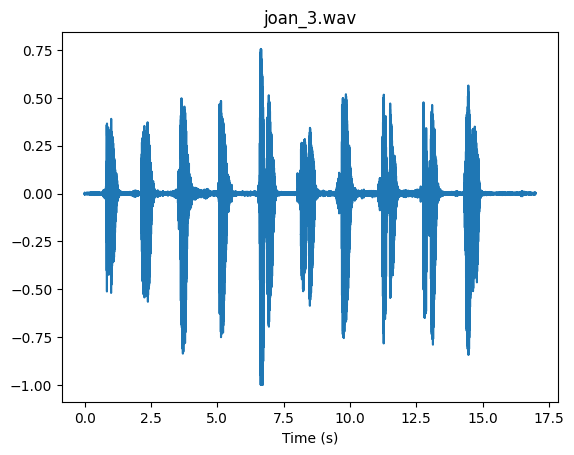

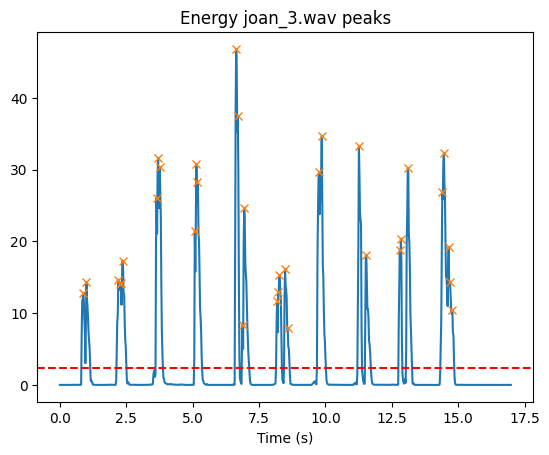

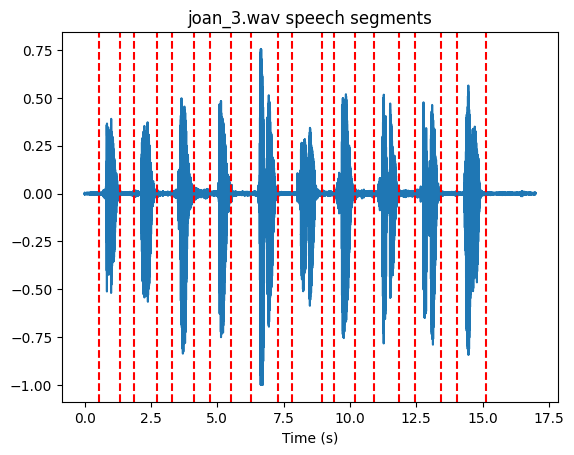

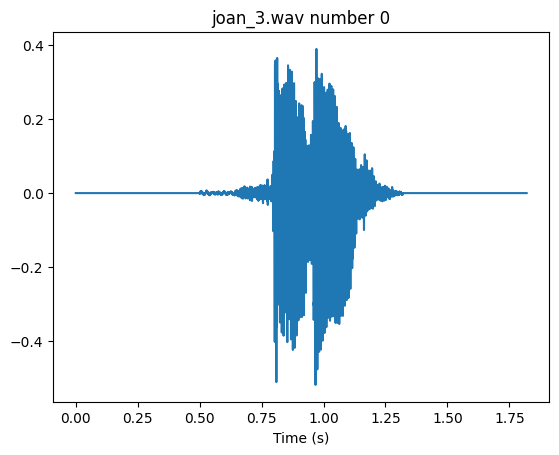

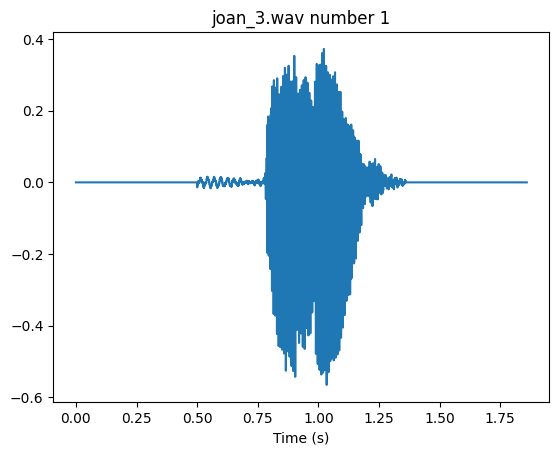

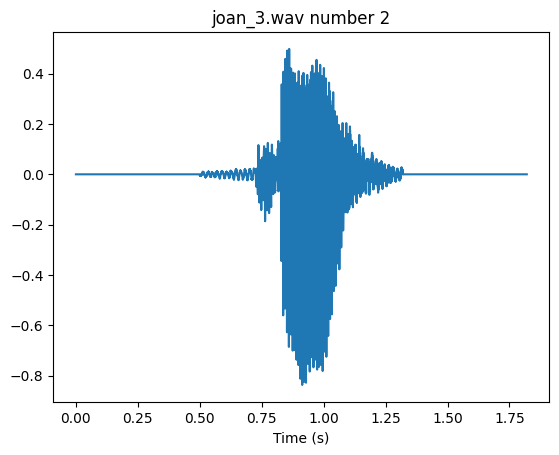

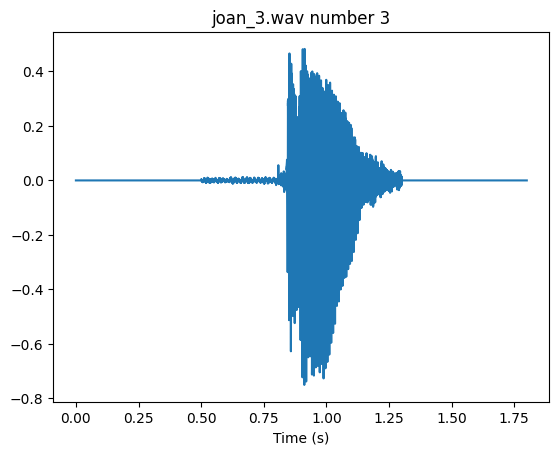

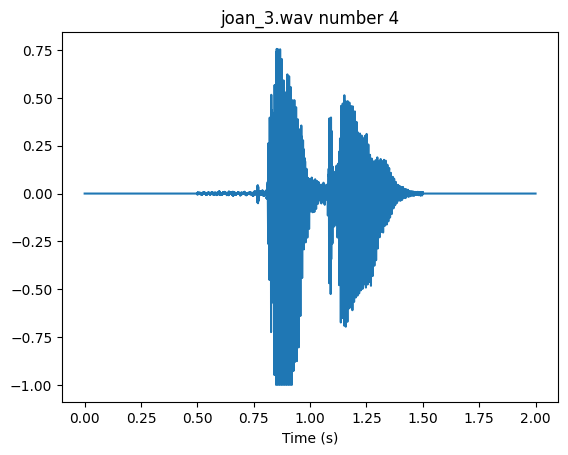

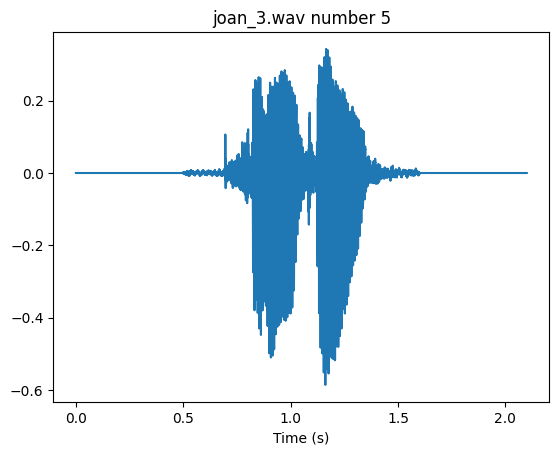

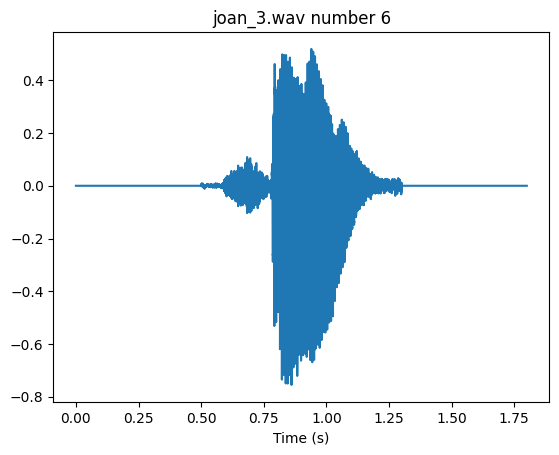

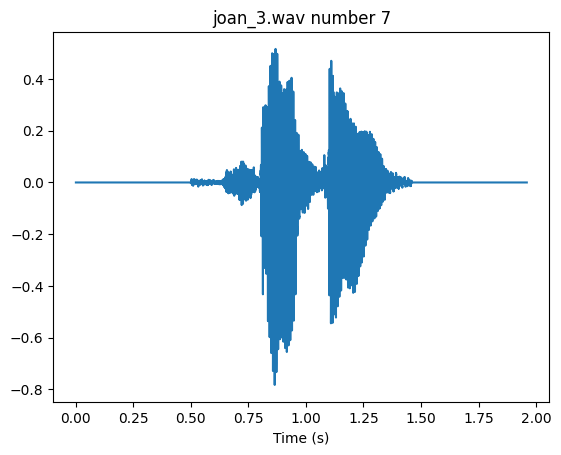

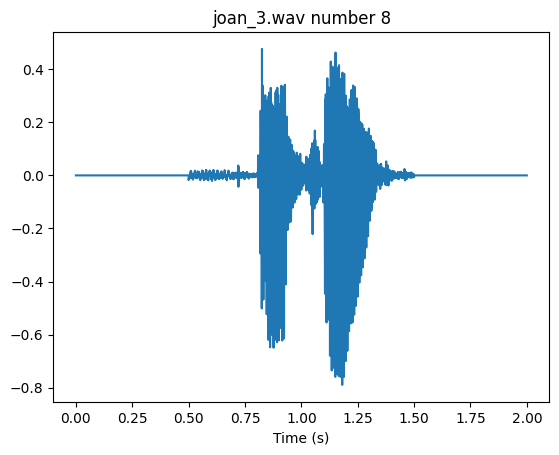

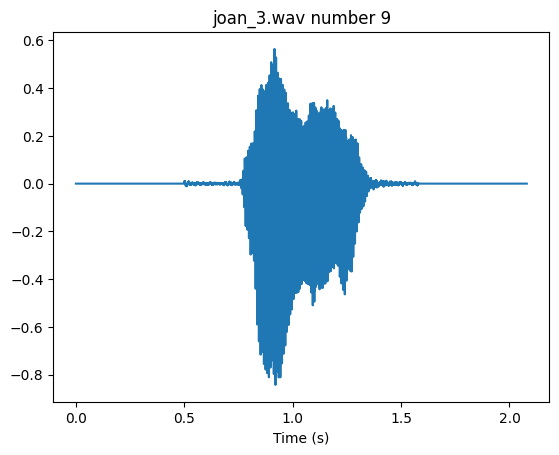

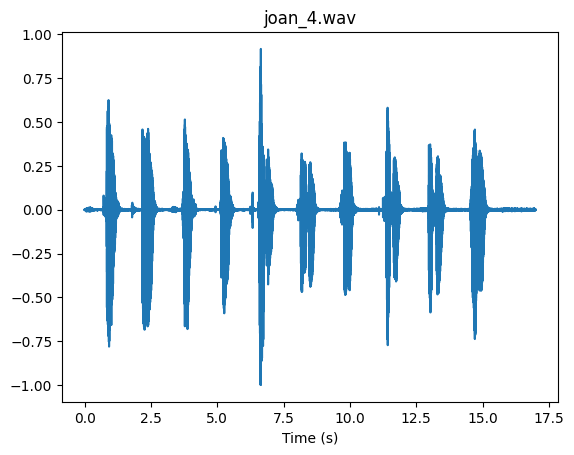

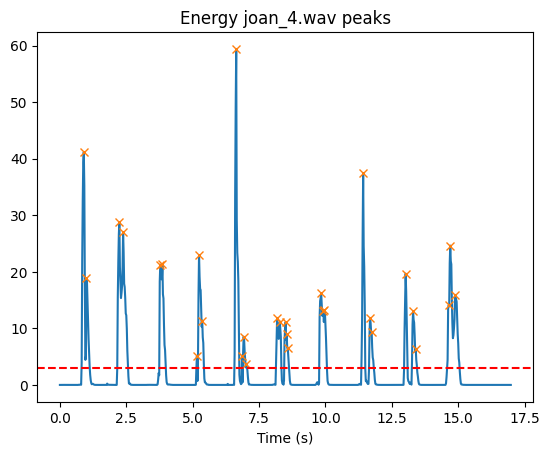

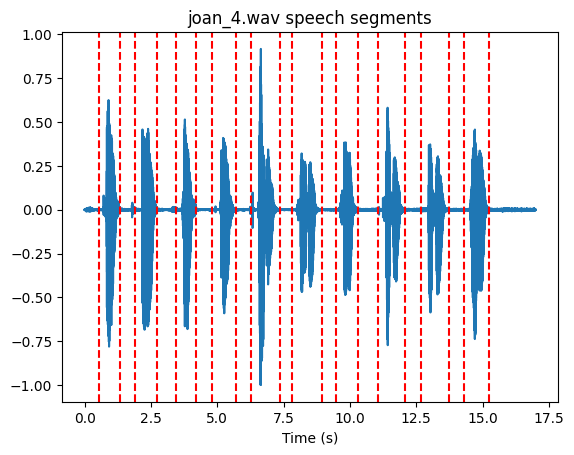

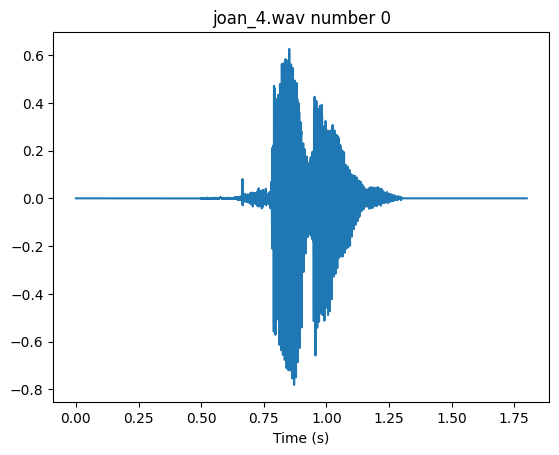

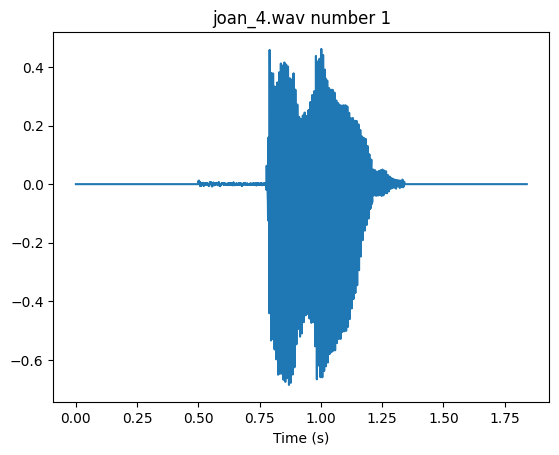

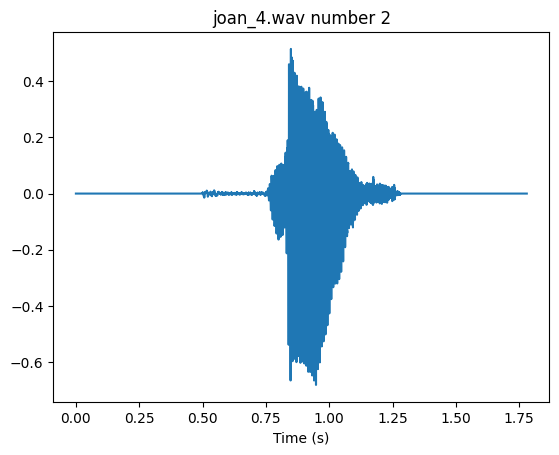

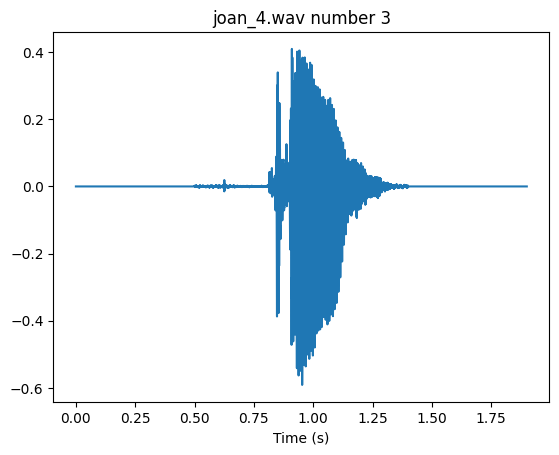

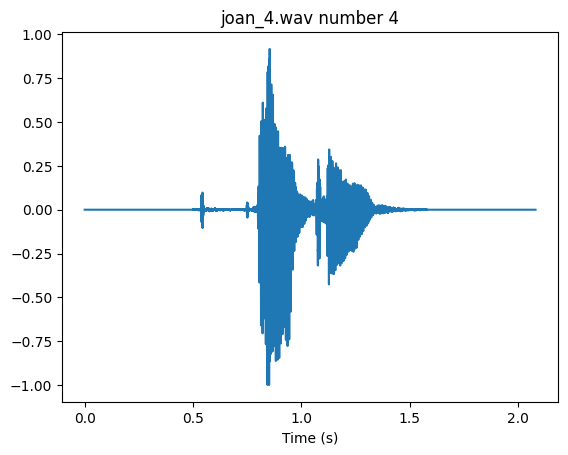

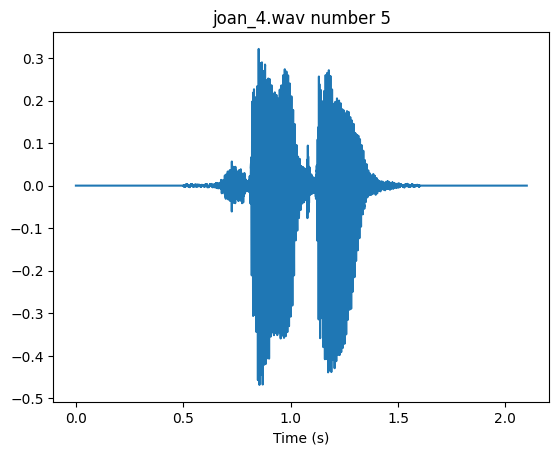

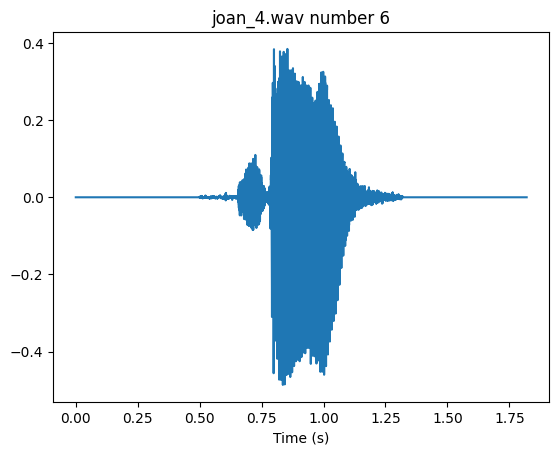

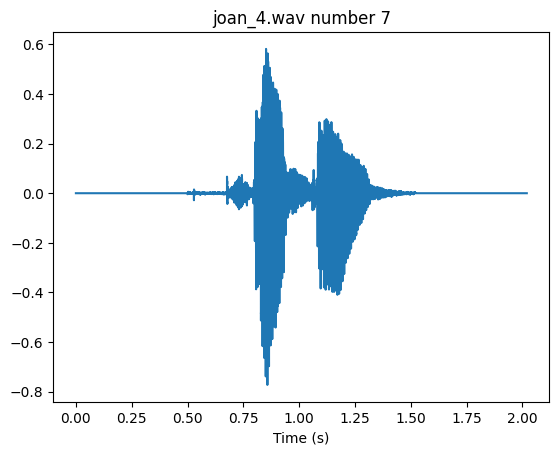

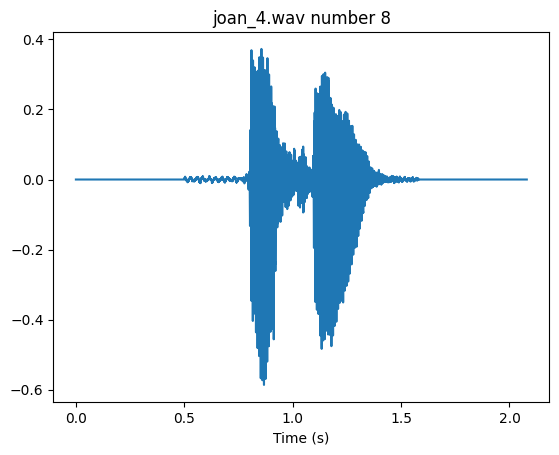

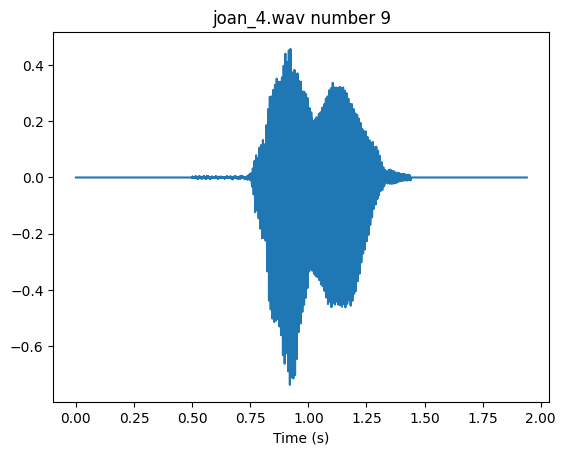

In [126]:
for person_id, directory in enumerate(sorted(os.listdir(AUDIO_DIR))):
    dir_path = os.path.join(AUDIO_DIR, directory)

    for record_id, file in enumerate(sorted(os.listdir(dir_path))):
        digits_name_dict = {
            0: "cero",
            1: "uno",
            2: "dos",
            3: "tres",
            4: "cuatro",
            5: "cinco",
            6: "seis",
            7: "siete",
            8: "ocho",
            9: "nueve",
        }

        signal = signal_from_file(os.path.join(dir_path, file))
        digits = speech_segments(signal, SPEECH_THRESHOLD, DISPERSION, method=METHOD)

        for i, digit in enumerate(digits):
            digit_name = digits_name_dict[i]

            digit_path = os.path.join(
                TARGET_DIR, f"{digit_name}_{person_id + 1}_{record_id + 1}.wav"
            )

            if os.path.exists(digit_path):
                os.remove(digit_path)

            wav.write(digit_path, signal.fs, digit)